In [1174]:
import numpy as np
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import cv2
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

In [1175]:
table = pd.read_csv('./train_data.txt', header=None)

In [1176]:
table.shape

(10740, 784)

In [1177]:
table_scaled= table/255.0

In [1178]:
scaled_data = table_scaled.values.reshape([-1,28,28,1])

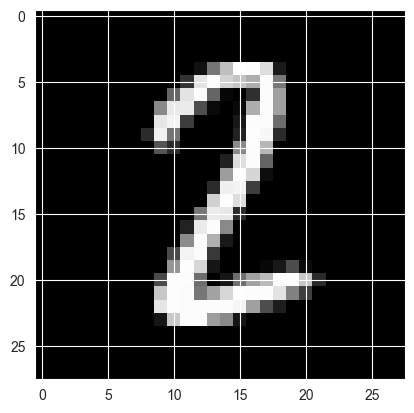

In [1179]:
plt.imshow(scaled_data[60],cmap='gray')

In [1204]:
def averaging(image):
    return cv2.blur(image,(3,3))

In [1205]:
def gaussian(image):
    return cv2.GaussianBlur(image,(3,3),0)

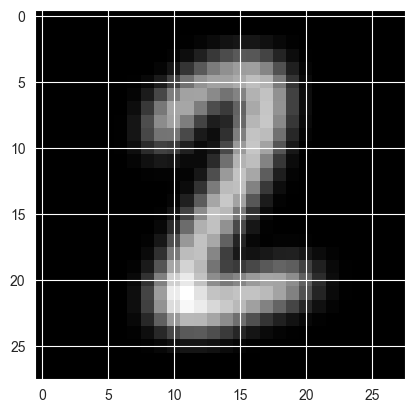

In [1206]:
plt.imshow(averaging(gaussian(scaled_data[60])), cmap='gray')

In [1207]:
image_transformed = []
for i in range(scaled_data.shape[0]):
    image_transformed.append(averaging(gaussian(scaled_data[i])).reshape(-1,784))
transformed_np_array = np.array(image_transformed)

In [1208]:
data = transformed_np_array.reshape(transformed_np_array.shape[0],transformed_np_array.shape[-1])

In [1209]:
data.shape

(10740, 784)

In [1210]:
pca = PCA(n_components=.99)
data = pca.fit_transform(data)

In [1211]:
data.shape

(10740, 65)

In [1212]:
tsne = TSNE(n_components=2,
            n_iter=5000,
            n_iter_without_progress=250,
            perplexity=19,
            early_exaggeration=26)
data_to_lower_dim = tsne.fit_transform(data)

/Users/bhabaranjanpanigrahi/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/Users/bhabaranjanpanigrahi/miniforge3/envs/mlp/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [1213]:
scaler = MinMaxScaler(feature_range=(1,1000))
data_scaled_and_transformed = scaler.fit_transform(data_to_lower_dim)

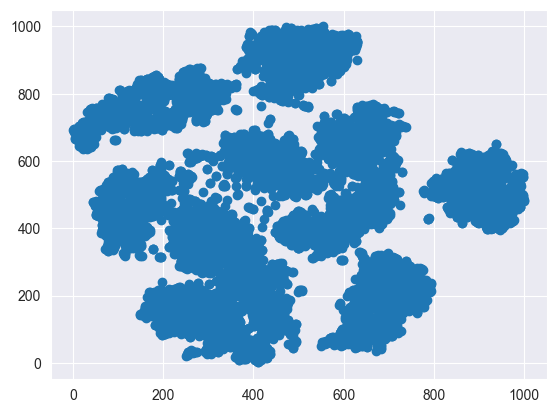

In [1214]:
plt.scatter(data_scaled_and_transformed[:,0], data_scaled_and_transformed[:,1])

In [1215]:
def generateKCentroid(data, k):
    random_index = [ np.random.randint(0,data.shape[0],size=data.shape[1]) for i in range(k)]
    centroids = []
    for i in range(len(random_index)):
        curr = random_index[i]
        build_centroid = []
        for j in range(len(curr)):
            build_centroid.append(data[curr[j],j])
        centroids.append(build_centroid)
    return np.array(centroids)

In [1216]:
def calculateInertia(data_set, centroid, cluster_assigned):
    sum_of_squared_distance = 0
    cluster_assigned = np.array(cluster_assigned)
    centroid = np.array(centroid)
    for i in range(cluster_assigned.shape[0]):
        distance = euclidean_distances(data_set[i].reshape(1,-1), centroid[cluster_assigned[i]].reshape(1,-1))
        sum_of_squared_distance += (distance*distance)
    return sum_of_squared_distance

In [1217]:
from sklearn.metrics.pairwise import euclidean_distances
def runKmeanClustering(cluster_size, train_data, centroids):
    iteration = 0
    while True:
        iteration += 1
        restart = False
        distance_e = euclidean_distances(train_data, centroids)
        distance = distance_e

        cluster_assigned  = np.argmin(distance, axis=1)
        cluster_bucket = {}

        for i in range(cluster_size):
            cluster_bucket[i] = []

        for index in range(cluster_assigned.shape[0]):
            cluster_bucket[cluster_assigned[index]].append(train_data[index])

        for cluster in range(cluster_size):
            if len(cluster_bucket[cluster]) == 0:
                print("cluster with ID=====> "+ str(cluster) + " does not have any data points" )
                print("re-initializing centroids")
                centroids = generateKCentroid(data, cluster_size)
                restart = True
                break

        if restart:
            print("re-staring k-means")
            continue
        centroid_of_cluster = []

        for cluster in range(cluster_size):
            centroid_of_cluster.append(np.mean(np.array(cluster_bucket[cluster]) ,axis=0))

        if np.array_equal(centroid_of_cluster, centroids):
            return centroids, cluster_assigned
        else:
            centroids = np.array(centroid_of_cluster)

In [1218]:
def runKmeansWithParams(train_data, num_cluster, init_cluster_size, step_increament = 1, num_iteration = 10):
    choosen_best_cluster_and_inertia = []
    cluster_to_process = []
    init_cluster = init_cluster_size

    for cluster in range(num_cluster):
        cluster_to_process.append(init_cluster + step_increament)
        init_cluster += step_increament

    for k in cluster_to_process:
        save_cluster =[]
        save_intertia = []
        print("cluster_size:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>", k)
        for i in range(num_iteration):
            print("iteration:================================================>", i)
            k_centroids, assigned_cluster = runKmeanClustering(k, train_data, generateKCentroid(train_data,k))
            save_cluster.append(assigned_cluster)
            save_intertia.append(calculateInertia(train_data,k_centroids,assigned_cluster))

        index = np.argmin(save_intertia)
        choosen_best_cluster_and_inertia.append((save_cluster[index], save_intertia[index]))

    return choosen_best_cluster_and_inertia

In [1219]:
data = data_scaled_and_transformed

In [1248]:
resulting_cluster = runKmeansWithParams(data,1,10,0,400)

cluster_size:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 10
iteration:================================================> 0
iteration:================================================> 1
cluster with ID=====> 5 does not have any data points
re-initializing centroids
re-staring k-means
iteration:================================================> 2
iteration:================================================> 3
iteration:================================================> 4
iteration:================================================> 5
iteration:================================================> 6
iteration:================================================> 7
iteration:================================================> 8
iteration:================================================> 9
iteration:================================================> 10
cluster with ID=====> 2 does not have any data points
re-initializing centroids
re-staring k-means
iteration:==========================================

In [1249]:
resulting_cluster

[(array([6, 4, 4, ..., 0, 7, 6]), array([[88250488.]], dtype=float32))]

In [1250]:
from sklearn.metrics import silhouette_score
silhouette_score(data, resulting_cluster[0][0])

0.4992995

In [1251]:
test_cluter = runKmeansWithParams(data,10,0,2)

cluster_size:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 2
iteration:================================================> 0
iteration:================================================> 1
iteration:================================================> 2
iteration:================================================> 3
iteration:================================================> 4
iteration:================================================> 5
iteration:================================================> 6
iteration:================================================> 7
iteration:================================================> 8
iteration:================================================> 9
cluster_size:>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>> 4
iteration:================================================> 0
iteration:================================================> 1
iteration:================================================> 2
iteration:================================================> 3


In [1252]:
test_cluter

[(array([1, 0, 0, ..., 0, 1, 1]), array([[7.671425e+08]], dtype=float32)),
 (array([2, 0, 0, ..., 1, 3, 3]), array([[3.4249488e+08]], dtype=float32)),
 (array([4, 5, 5, ..., 1, 0, 4]), array([[1.9872973e+08]], dtype=float32)),
 (array([1, 0, 0, ..., 4, 3, 1]), array([[1.2275579e+08]], dtype=float32)),
 (array([8, 5, 5, ..., 6, 0, 8]), array([[88250488.]], dtype=float32)),
 (array([9, 0, 0, ..., 5, 7, 9]), array([[69658752.]], dtype=float32)),
 (array([ 2, 13, 13, ...,  3,  1, 12]), array([[58855000.]], dtype=float32)),
 (array([13, 10, 10, ..., 12,  6,  7]), array([[50701572.]], dtype=float32)),
 (array([10,  4,  4, ...,  2, 11,  1]), array([[44497540.]], dtype=float32)),
 (array([ 5, 17, 17, ...,  2,  9,  7]), array([[42124176.]], dtype=float32))]

In [1253]:
silhouette_metric = []
inertia = []
for i in range(10):
  silhouette_metric.append(silhouette_score(data, test_cluter[i][0]))
  inertia.append(test_cluter[i][1][0][0])

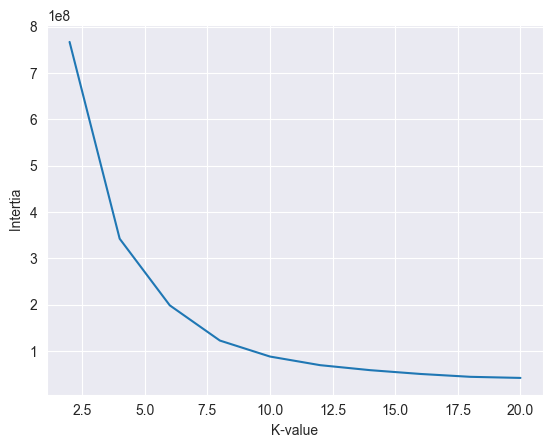

In [1254]:
plt.xlabel("K-value")
plt.ylabel(" Intertia ")
plt.plot([ i*2 for i in range(1,11)], inertia)

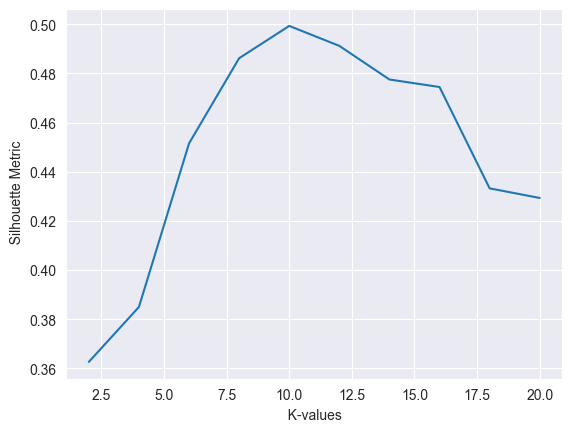

In [1255]:
plt.xlabel("  K-values  " )
plt.ylabel("  Silhouette Metric ")
plt.plot([ i*2 for i in range(1,11)], silhouette_metric)

In [1256]:
resulting_cluster[0][0]

array([6, 4, 4, ..., 0, 7, 6])

In [1259]:
assigned_cluster = resulting_cluster[0][0]
print(assigned_cluster)

[6 4 4 ... 0 7 6]


In [1260]:
assigned_cluster = assigned_cluster + 1
print(assigned_cluster)

[7 5 5 ... 1 8 7]


In [1261]:
import csv
outfile = open('./results.csv','w')
out = csv.writer(outfile)
out.writerows(map(lambda x: [x], assigned_cluster))
outfile.close()